<a href="https://colab.research.google.com/github/Akshidha-Unni/Predicting-ADHD-From-High-Dimensional-Neuroimaging-Data/blob/main/ADHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Reading the dataset
2. ⁠Cleaning the data (null values , unwanted rows)
3. ⁠Stratified train test split
4. ⁠Scale the data
5. ⁠PCA or LDA ( try feature selection as well)
6. ⁠Eda plots
7. ⁠Baseline model
8. ⁠Model building (with class weights) + evaluation
9. ⁠Hyperparameter tuning + importance
10. ⁠variable importance (plot)
11. ⁠model components plot (qq , residual -4 plots)
12. ⁠confusion matrix , precision recall curve , roc curve.
13. Confidence interval

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshidhaunni","key":"ab814c224e73de69c38514b14cbd5d00"}'}

In [ ]:
!pip install openpyxl

In [ ]:
!pip install impyute

In [ ]:
!pip install kaggle

In [ ]:
import shutil
import os
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, jaccard_score

In [ ]:
if not os.path.exists("/root/.kaggle/kaggle.json"):
    os.makedirs("/root/.kaggle", exist_ok=True)
    shutil.move("kaggle.json", "/root/.kaggle/")
    os.chmod("/root/.kaggle/kaggle.json", 600)
else:
    print("kaggle.json already exists in /root/.kaggle/")

In [ ]:
!kaggle competitions download -c widsdatathon2025 -p /content/data

In [ ]:
import zipfile

with zipfile.ZipFile("/content/data/widsdatathon2025.zip", "r") as zip_ref:
    zip_ref.extractall("/content/data")

os.listdir("/content/data")

['TRAIN_NEW',
 'TRAIN_OLD',
 'widsdatathon2025.zip',
 'Data Dictionary.xlsx',
 'SAMPLE_SUBMISSION.xlsx',
 'TEST']

In [ ]:
train_sols = pd.read_excel("/content/data/TRAIN_OLD/TRAINING_SOLUTIONS.xlsx")
train_sols

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1
...,...,...,...
1208,Atx7oub96GXS,0,0
1209,groSbUfkQngM,0,1
1210,zmxGvIrOD0bt,0,1
1211,rOmWFuJCud5G,0,0


In [ ]:
train_cat = pd.read_excel("/content/data/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx")
train_cat

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0
2,Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0
3,p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0
4,M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0
...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,2019,1,0.0,0,2,21,40,21,40
1209,groSbUfkQngM,2016,1,0.0,0,1,18,35,0,0
1210,zmxGvIrOD0bt,2015,1,1.0,2,1,18,20,0,0
1211,rOmWFuJCud5G,2018,3,0.0,8,3,21,40,18,45


In [ ]:
train_func = pd.read_csv("/content/data/TRAIN_OLD/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")
train_func

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,...,0.003404,-0.010359,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372
1,WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,...,-0.008409,-0.008479,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200
2,4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,...,0.053245,-0.028003,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162
3,obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,...,-0.023918,-0.005356,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584
4,s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,kTurROKp5YHQ,0.022932,0.024830,-0.006514,0.021070,0.093365,0.083369,0.010991,0.035838,0.023909,...,0.060060,-0.003911,-0.016413,0.089110,0.118587,-0.060868,0.124443,0.028510,0.113064,0.103809
1209,FCRyMz9O6yCq,0.047078,0.135955,0.144366,0.054938,0.065760,0.113550,0.032621,0.025349,0.011848,...,0.021318,0.020141,-0.020920,0.030450,0.190241,0.026461,-0.011593,0.139483,-0.064480,0.070354
1210,vm2P1hmAY1hl,0.094541,0.145280,0.061964,0.030562,0.078278,0.105857,0.043984,0.039145,0.032024,...,-0.052990,-0.002118,-0.038452,0.066608,0.143446,0.051221,0.127495,0.106242,-0.036065,0.151341
1211,OFxvN8lnw21w,-0.001533,0.128562,0.045000,-0.008742,0.003673,0.086494,0.090101,-0.037449,-0.026334,...,0.024479,-0.036995,-0.061617,-0.001699,0.106568,0.023427,-0.003520,0.174972,0.041198,0.152029


In [ ]:
train_quant = pd.read_excel("/content/data/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_quant

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,87.80,14,5,14,39,20,15,21,1,9,2,7,3,6,2,0,9,10.697923
1209,groSbUfkQngM,77.80,14,3,10,32,20,11,23,6,18,3,11,9,5,7,4,7,13.964750
1210,zmxGvIrOD0bt,16.68,14,3,16,28,15,19,27,3,4,1,3,0,0,1,0,10,NaN
1211,rOmWFuJCud5G,53.40,14,3,14,34,18,23,23,4,9,0,9,3,5,0,0,9,12.089094


In [ ]:
#checking null values in train_cat
train_cat[train_cat.columns[train_cat.isna().sum() > 0]].isna().sum()

,0
PreInt_Demos_Fam_Child_Ethnicity,11


In [ ]:
# Impute missing values with '-1'
train_cat["PreInt_Demos_Fam_Child_Ethnicity"] = train_cat["PreInt_Demos_Fam_Child_Ethnicity"].fillna(-1)


In [ ]:
#checking whether imputation successful
train_cat.columns[train_cat.isna().sum() > 0]

Index([], dtype='object')

In [ ]:
#checking null values in train_func
train_func[train_func.columns[train_func.isna().sum() > 0]].isna().sum()

,0


In [ ]:
#checking null values in train_func
train_quant[train_quant.columns[train_quant.isna().sum() > 0]].isna().sum()

,0
MRI_Track_Age_at_Scan,360


In [ ]:
#MICE imputation for Train_cat
numerical_features_q = train_quant.select_dtypes(include=np.number).columns
numerical_data_q = train_quant[numerical_features_q]

imputer = IterativeImputer(max_iter=3, random_state=0)
imputed_array_q = imputer.fit_transform(numerical_data_q)
imputed_numerical_train_quant = pd.DataFrame(imputed_array_q, columns=numerical_features_q)

imputed_train_quant = pd.concat([train_quant.drop(columns=numerical_features_q), imputed_numerical_train_quant], axis=1)


In [ ]:
#checking whether imputation successful
imputed_train_quant.columns[imputed_train_quant.isna().sum() > 0]

Index([], dtype='object')

In [ ]:
merged_train = train_sols.merge(train_cat, on="participant_id", how="inner").merge(train_func, on="participant_id", how="inner").merge(imputed_train_quant, on="participant_id", how="inner")

In [ ]:
merged_train = merged_train.drop(columns=['participant_id'])

In [ ]:
X = merged_train.drop(columns=['ADHD_Outcome','Sex_F'])
y = merged_train[['ADHD_Outcome','Sex_F']]


In [ ]:
y['Sex_F'].value_counts()

,count
Sex_F,
0,797
1,416


In [ ]:
merged_train.shape

(1213, 19929)

Baseline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y['ADHD_Outcome'])

In [ ]:
#logistic regression
base_model = MultiOutputClassifier(LogisticRegression(solver='saga', max_iter=100))
base_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


MultiOutputClassifier(estimator=LogisticRegression(solver='saga'))

In [ ]:
y_pred = base_model.predict(X_test)

In [ ]:
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average="macro")
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
jaccard_score = jaccard_score(y_test, y_pred, average='micro')
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision Micro: {precision_micro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
print(f"Jaccard Score: {jaccard_score:.4f}")

Micro F1 Score: 0.6878
Macro F1 Score: 0.4201
Precision Micro: 0.7309
Recall Micro: 0.6494
Accuracy Score: 0.5144
Jaccard Score: 0.5241


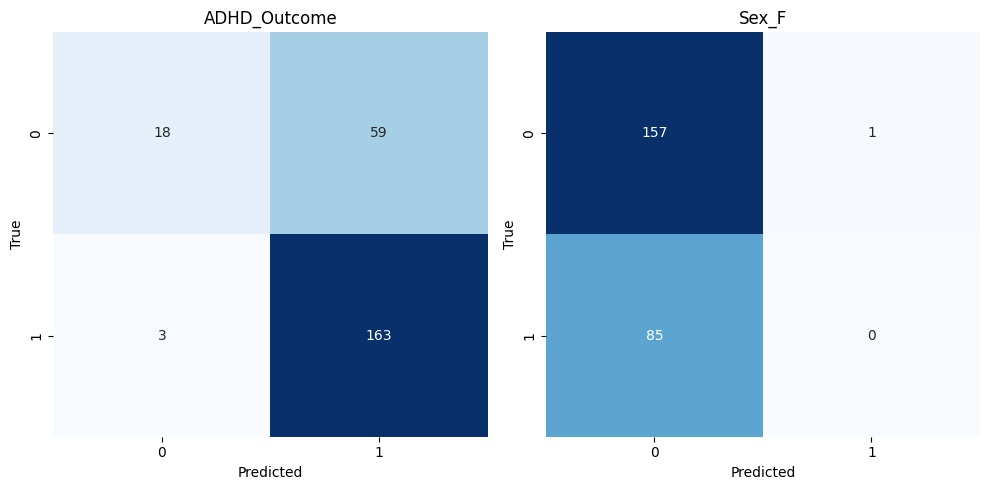

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrices for each label separately
cm = multilabel_confusion_matrix(y_test, y_pred)
num_labels = cm.shape[0]

# Plot confusion matrices
fig, axes = plt.subplots(1, num_labels, figsize=(5 * num_labels, 5))
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{y_test.columns[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

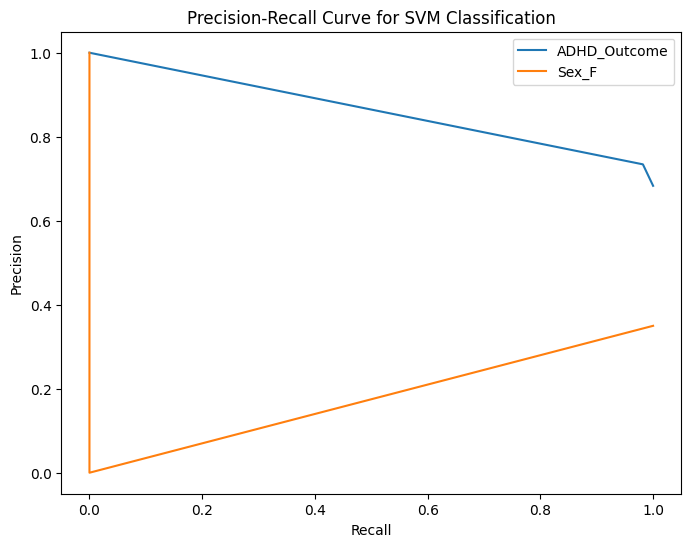

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate over columns with their names
    precision, recall, _ = precision_recall_curve(y_test[column_name], y_pred[:, i])
    plt.plot(recall, precision, label=f"{column_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM Classification")
plt.legend()
plt.show()


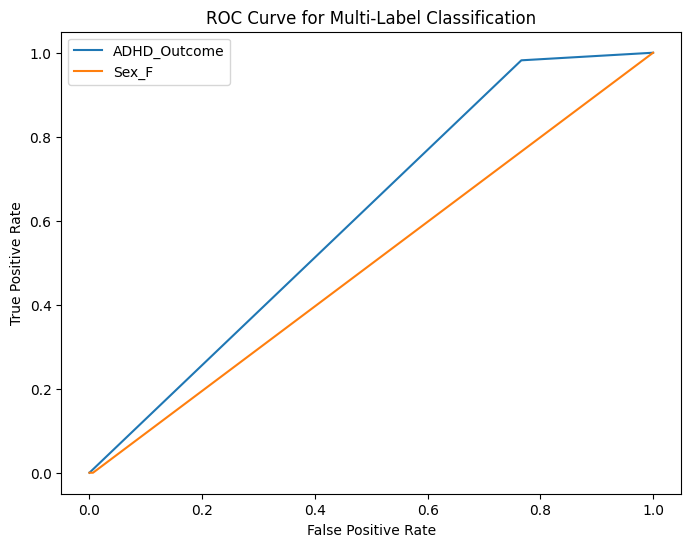

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve for each label
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate through columns with names
    fpr, tpr, _ = roc_curve(y_test[column_name], y_pred[:, i])  # Access column by name
    plt.plot(fpr, tpr, label=f"{column_name}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Label Classification")
plt.legend()
plt.show()

Feature Selection

In [ ]:
#feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Initialize a dictionary to store selected features per label
selected_features = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y['ADHD_Outcome'])

for col in y_train.columns:
    l1_selector = LogisticRegression(penalty='l1', solver='liblinear', C=1)
    l1_selector.fit(X_train, y_train[col])  # Train separately for each label

    # Select features
    model = SelectFromModel(l1_selector, prefit=True)
    selected_features[col] = model.get_support()  # Boolean mask of selected features

# Combine selected features (keep only features selected for at least one label)
final_features = np.any(np.array(list(selected_features.values())), axis=0)

# Transform datasets
X_train_selected = X_train.iloc[:, final_features]
X_test_selected = X_test.iloc[:, final_features]


print(f"Original feature count: {X_train.shape[1]}")
print(f"Selected feature count: {X_train_selected.shape[1]}")

Original feature count: 19927
Selected feature count: 478


<ipython-input-88-ca401c0bddf5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance, y=top_features, palette='Blues')


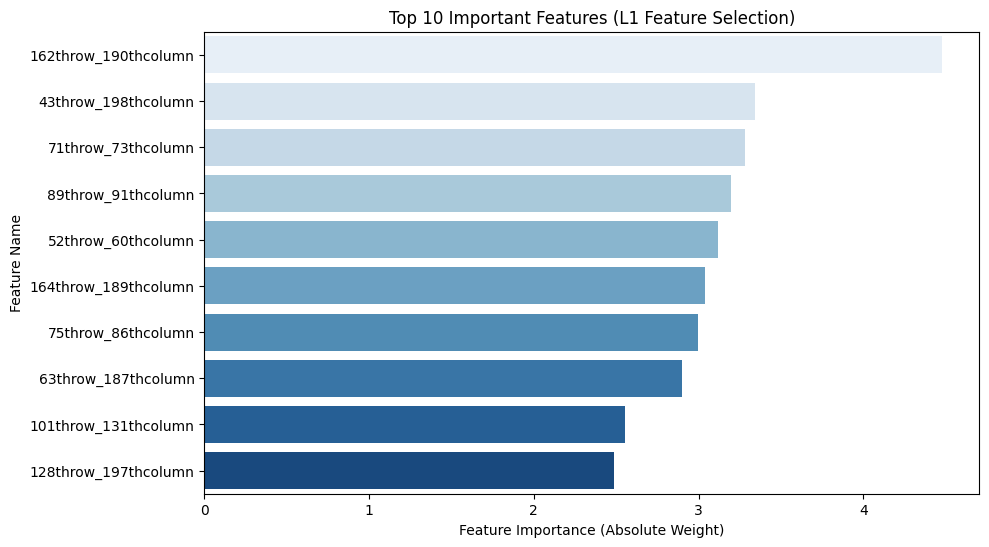

In [ ]:
feature_names = np.array(X_train.columns)

# Compute absolute coefficients and sum across labels
feature_importance = np.zeros(X_train.shape[1])

for col in y_train.columns:
    l1_selector = LogisticRegression(penalty='l1', solver='liblinear', C=1)
    l1_selector.fit(X_train, y_train[col])
    feature_importance += np.abs(l1_selector.coef_).flatten()
# Sort features by importance
top_indices = np.argsort(feature_importance)[-10:][::-1] # Get indices of top 10 features
top_features = feature_names[top_indices]
top_importance = feature_importance[top_indices]

# Plot Top 10 Features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importance, y=top_features, palette='Blues')
plt.xlabel("Feature Importance (Absolute Weight)")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features (L1 Feature Selection)")
plt.show()

Scaling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_selected)
X_test = scaler.transform(X_test_selected)


Modeling

Tuned LR

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define parameter grid
param_grid = {
    'estimator__C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'estimator__penalty': ['l1', 'l2'],  # L1/L2 regularization
}

# Create base model
base_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)  # Use liblinear for L1/L2
multi_model = MultiOutputClassifier(base_model, n_jobs=-1)

# Define scoring metric (F1-micro)
scorer = make_scorer(f1_score, average='micro')

# Perform Grid Search
grid_search = GridSearchCV(multi_model, param_grid, scoring=scorer, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred = grid_search.best_estimator_.predict(X_test)
print("Final F1 Score (Micro):", f1_score(y_test, y_pred, average='micro'))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2'}
Final F1 Score (Micro): 0.7383367139959433


In [ ]:
lr_best = grid_search.best_estimator_
lr_best.fit(X_train, y_train)
y_pred = lr_best.predict(X_test)

# Evaluate
from sklearn.metrics import f1_score
print("F1 Micro:", f1_score(y_test, y_pred, average='micro'))

F1 Micro: 0.7383367139959433


In [ ]:
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average="macro")
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
# jaccard_score = jaccard_score(y_test, y_pred, average="samples")
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision Micro: {precision_micro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
# print(f"Jaccard Score: {jaccard_score:.4f}")

Micro F1 Score: 0.7383
Macro F1 Score: 0.6858
Precision Micro: 0.7521
Recall Micro: 0.7251
Accuracy Score: 0.5556


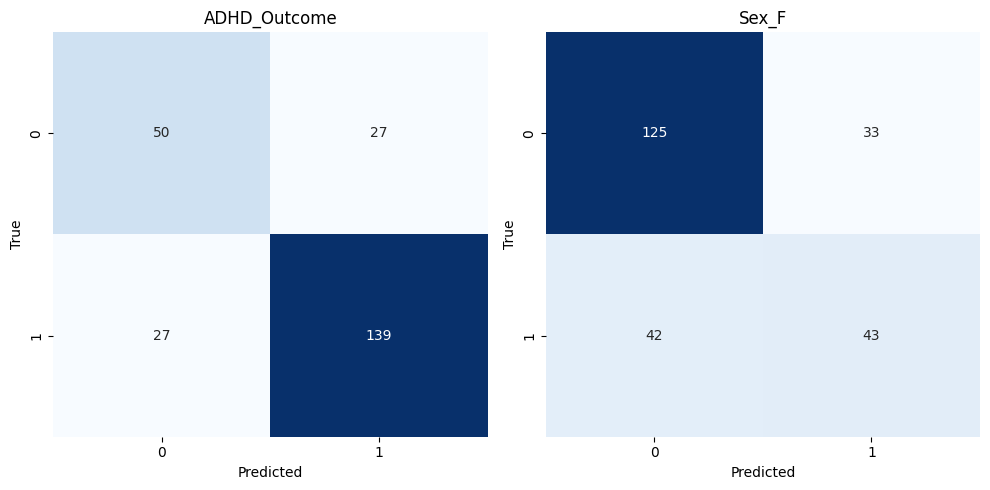

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrices for each label separately
cm = multilabel_confusion_matrix(y_test, y_pred)
num_labels = cm.shape[0]

# Plot confusion matrices
fig, axes = plt.subplots(1, num_labels, figsize=(5 * num_labels, 5))
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{y_test.columns[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

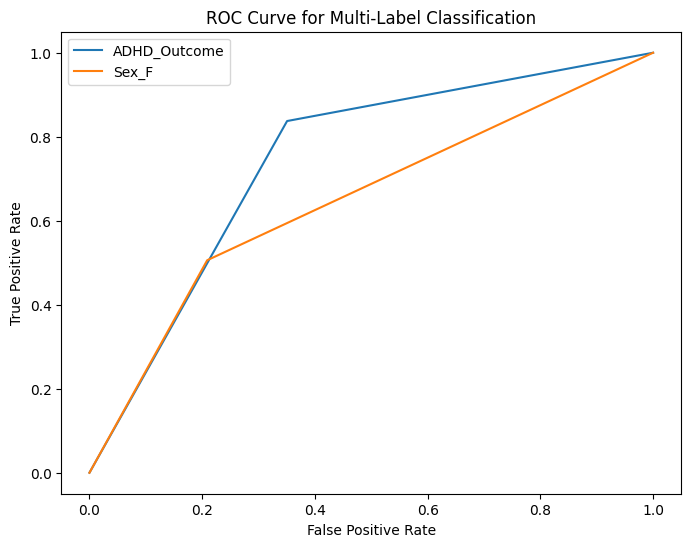

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve for each label
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate through columns with names
    fpr, tpr, _ = roc_curve(y_test[column_name], y_pred[:, i])  # Access column by name
    plt.plot(fpr, tpr, label=f"{column_name}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Label Classification")
plt.legend()
plt.show()

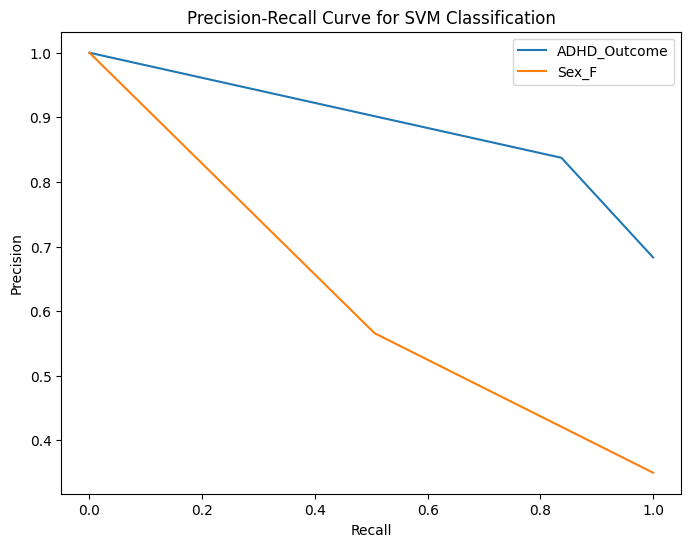

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate over columns with their names
    precision, recall, _ = precision_recall_curve(y_test[column_name], y_pred[:, i])
    plt.plot(recall, precision, label=f"{column_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM Classification")
plt.legend()
plt.show()


Tuned XGB

In [ ]:
#XGB Tune using randomsearch
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define parameter grid
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 5, 10]  # Adjust based on class imbalance
}

# Initialize model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist,
    scoring='f1_micro', n_iter=20, cv=3, verbose=2, n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Micro Score:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best F1 Micro Score: 0.7982211733623842


In [ ]:
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

# Evaluate
from sklearn.metrics import f1_score
print("F1 Micro:", f1_score(y_test, y_pred, average='micro'))

F1 Micro: 0.7370441458733206


In [ ]:
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average="macro")
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
# jaccard_score = jaccard_score(y_test, y_pred, average="samples")
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision Micro: {precision_micro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
# print(f"Jaccard Score: {jaccard_score:.4f}")

Micro F1 Score: 0.7370
Macro F1 Score: 0.6618
Precision Micro: 0.7111
Recall Micro: 0.7649
Accuracy Score: 0.4979


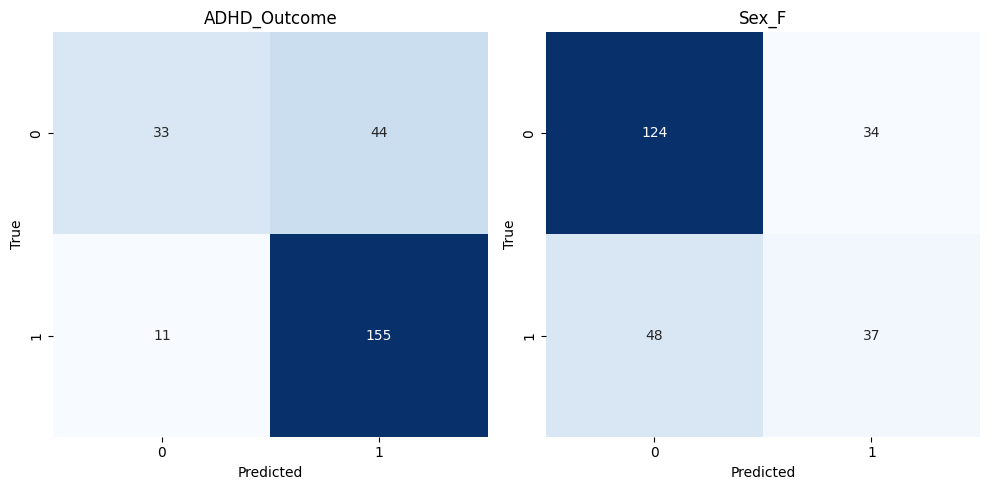

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrices for each label separately
cm = multilabel_confusion_matrix(y_test, y_pred)
num_labels = cm.shape[0]

# Plot confusion matrices
fig, axes = plt.subplots(1, num_labels, figsize=(5 * num_labels, 5))
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{y_test.columns[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

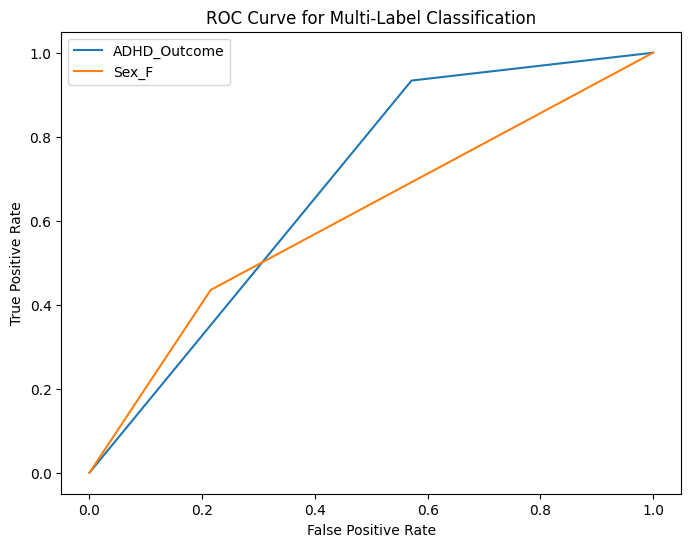

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve for each label
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate through columns with names
    fpr, tpr, _ = roc_curve(y_test[column_name], y_pred[:, i])  # Access column by name
    plt.plot(fpr, tpr, label=f"{column_name}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Label Classification")
plt.legend()
plt.show()

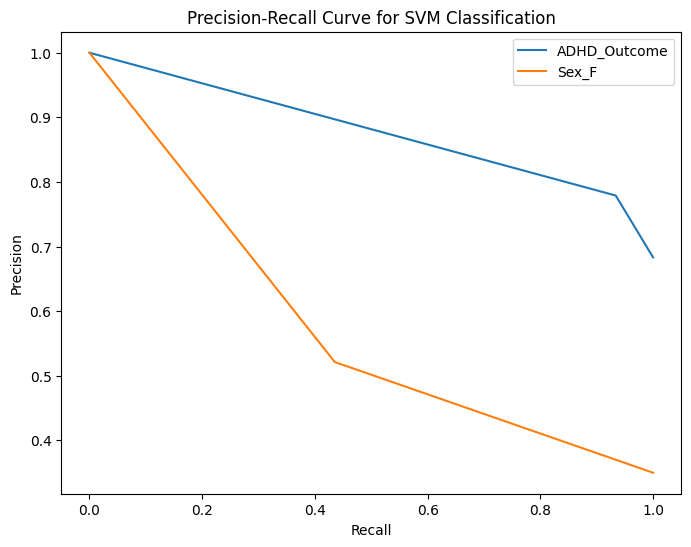

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate over columns with their names
    precision, recall, _ = precision_recall_curve(y_test[column_name], y_pred[:, i])
    plt.plot(recall, precision, label=f"{column_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM Classification")
plt.legend()
plt.show()


Tuned LGBM

In [ ]:
# Initialize LGBM model
base_lgbm = LGBMClassifier(objective='binary',class_weight = 'balanced', random_state=42)

# Wrap LGBM in MultiOutputClassifier
multi_lgbm = MultiOutputClassifier(base_lgbm, n_jobs=-1)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'estimator__n_estimators': [100, 300, 500],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [-1, 5, 10],
    'estimator__num_leaves': [31, 50, 100],
    'estimator__min_child_samples': [10, 20, 30],
    'estimator__subsample': [0.7, 0.8, 1.0],
    'estimator__colsample_bytree': [0.7, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    multi_lgbm, param_distributions=param_dist,
    scoring='f1_micro', n_iter=20, cv=3, verbose=2, n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best parameters and model evaluation
y_pred = random_search.best_estimator_.predict(X_test)
f1 = f1_score(y_test, y_pred, average='micro')

print("Best Parameters:", random_search.best_params_)
print("F1 Score (micro):", f1)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'estimator__subsample': 0.8, 'estimator__num_leaves': 50, 'estimator__n_estimators': 500, 'estimator__min_child_samples': 30, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.05, 'estimator__colsample_bytree': 0.7}
F1 Score (micro): 0.7225806451612903


In [ ]:
print(random_search.best_score_)

0.7826375194901892


In [ ]:
best_lgb = random_search.best_estimator_
best_lgb.fit(X_train, y_train)
y_pred = best_lgb.predict(X_test)

# Evaluate
from sklearn.metrics import f1_score
print("F1 Micro:", f1_score(y_test, y_pred, average='micro'))

F1 Micro: 0.7225806451612903


In [ ]:
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average="macro")
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
# jaccard_score = jaccard_score(y_test, y_pred, average="samples")
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision Micro: {precision_micro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
# print(f"Jaccard Score: {jaccard_score:.4f}")

Micro F1 Score: 0.7226
Macro F1 Score: 0.5793
Precision Micro: 0.7850
Recall Micro: 0.6693
Accuracy Score: 0.5432


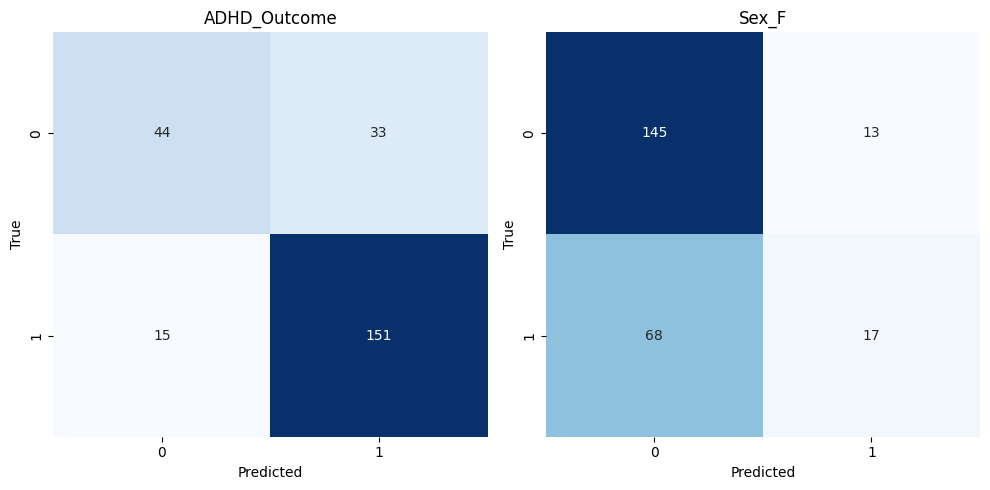

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrices for each label separately
cm = multilabel_confusion_matrix(y_test, y_pred)
num_labels = cm.shape[0]

# Plot confusion matrices
fig, axes = plt.subplots(1, num_labels, figsize=(5 * num_labels, 5))
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{y_test.columns[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

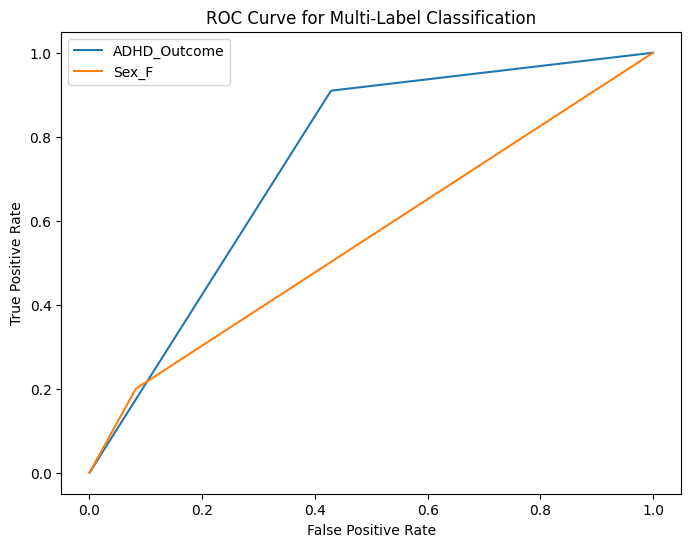

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve for each label
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate through columns with names
    fpr, tpr, _ = roc_curve(y_test[column_name], y_pred[:, i])  # Access column by name
    plt.plot(fpr, tpr, label=f"{column_name}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Label Classification")
plt.legend()
plt.show()

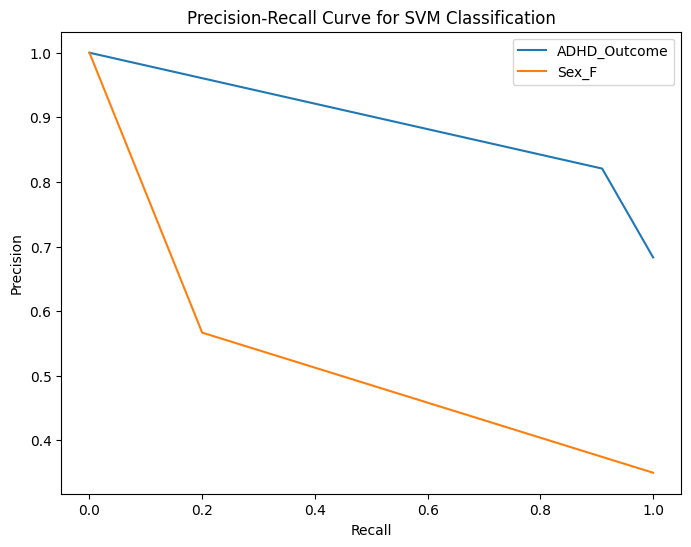

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate over columns with their names
    precision, recall, _ = precision_recall_curve(y_test[column_name], y_pred[:, i])
    plt.plot(recall, precision, label=f"{column_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM Classification")
plt.legend()
plt.show()


Tuned SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, make_scorer

# Define parameter grid for SVC
param_grid = {
    'estimator__C': [0.1, 1, 10],  # Regularization parameter
    # 'estimator__kernel': ['linear', 'rbf'],  # Kernel type
    'estimator__gamma': ['scale', 'auto'],  # Kernel coefficient
    'estimator__degree': [3, 5],  # Polynomial degree (only for 'poly' kernel)
}

# Initialize base SVM model
svm_model = SVC(kernel ="linear", random_state=42)

# Wrap SVM with MultiOutputClassifier for multi-label classification
multi_svm = MultiOutputClassifier(svm_model, n_jobs=-1)

# Use f1_micro as scoring
scorer = make_scorer(f1_score, average='micro')

# Perform GridSearchCV
grid_search = GridSearchCV(
    multi_svm, param_grid, scoring=scorer, cv=3, n_jobs=-1, verbose=2
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best Parameters:", grid_search.best_params_)




Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'estimator__C': 0.1, 'estimator__degree': 3, 'estimator__gamma': 'scale'}


In [ ]:
print("best score", grid_search.best_score_)

best score 0.7571132145933234


In [ ]:
grid_search.best_estimator_.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)
f1_micro = f1_score(y_test, y_pred, average='micro')
print("Best F1 Micro Score:", f1_micro)

Best F1 Micro Score: 0.7531380753138075


In [ ]:
best_svm = grid_search.best_estimator_

In [ ]:
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average="macro")
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
# jaccard_score = jaccard_score(y_test, y_pred, average="samples")
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision Micro: {precision_micro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
# print(f"Jaccard Score: {jaccard_score:.4f}")

Micro F1 Score: 0.7531
Macro F1 Score: 0.6570
Precision Micro: 0.7930
Recall Micro: 0.7171
Accuracy Score: 0.5679


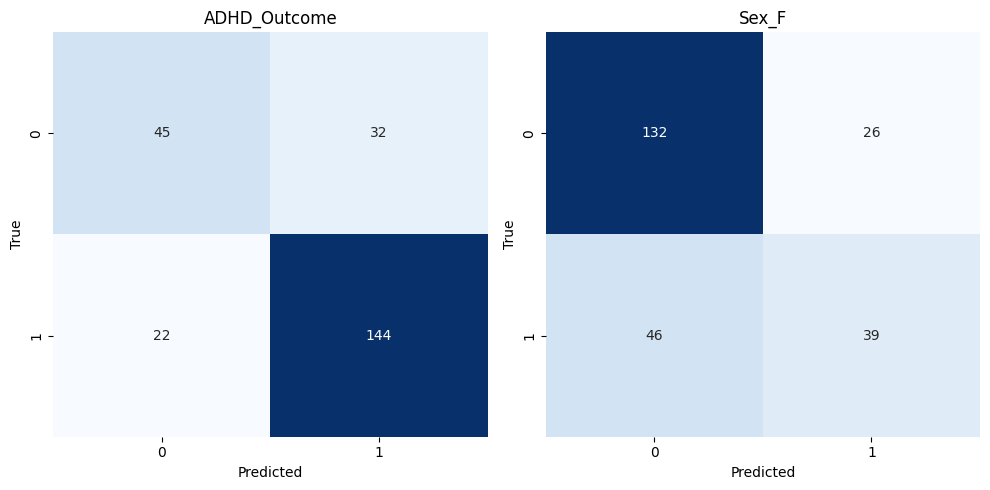

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrices for each label separately
cm = multilabel_confusion_matrix(y_test, y_pred)
num_labels = cm.shape[0]

# Plot confusion matrices
fig, axes = plt.subplots(1, num_labels, figsize=(5 * num_labels, 5))
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{y_test.columns[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

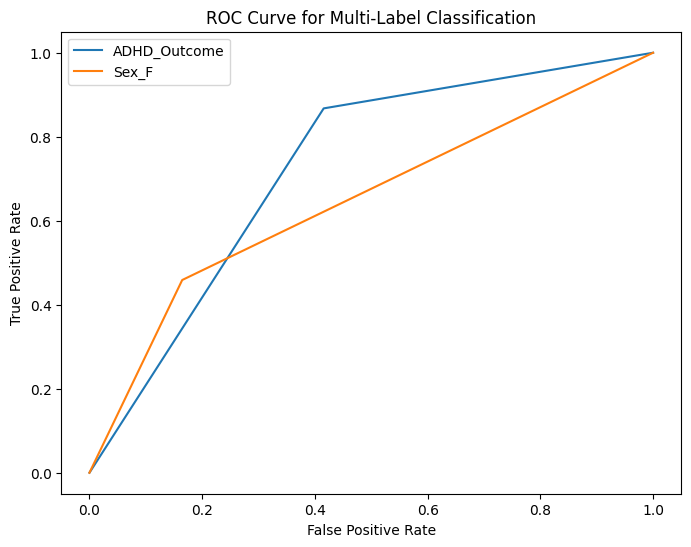

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve for each label
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate through columns with names
    fpr, tpr, _ = roc_curve(y_test[column_name], y_pred[:, i])  # Access column by name
    plt.plot(fpr, tpr, label=f"{column_name}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Label Classification")
plt.legend()
plt.show()

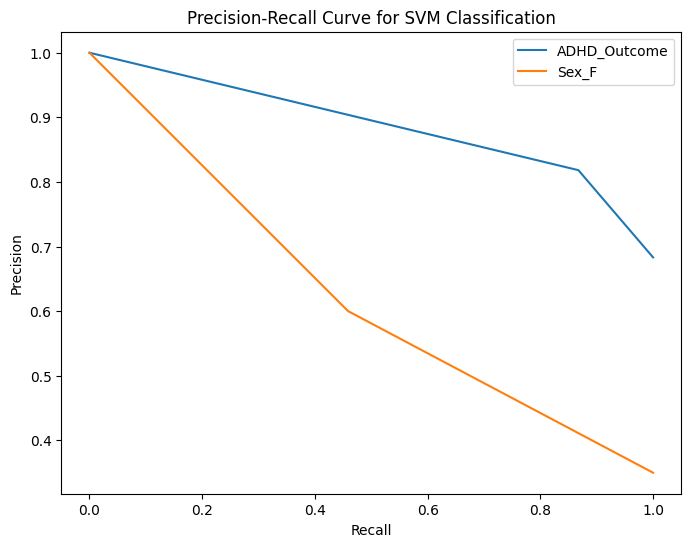

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate over columns with their names
    precision, recall, _ = precision_recall_curve(y_test[column_name], y_pred[:, i])
    plt.plot(recall, precision, label=f"{column_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM Classification")
plt.legend()
plt.show()


Stacking

In [ ]:
# Define base estimators

base_estimators = [
    ('lr', LogisticRegression(solver='liblinear', max_iter=1000,C= 0.1, penalty='l2', class_weight='balanced')),
    ('svm', SVC(kernel='linear', C=0.1, degree = 3, gamma='scale', random_state=42))
]

In [ ]:
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(solver='liblinear', max_iter=100, class_weight='balanced'),
    cv=5
)

In [ ]:
# Wrap the stacking model in a MultiOutputClassifier
multi_output_model = MultiOutputClassifier(stacking_model, n_jobs=-1)

# Fit the model
multi_output_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=StackingClassifier(cv=5,
                                                   estimators=[('lr',
                                                                LogisticRegression(C=0.1,
                                                                                   class_weight='balanced',
                                                                                   max_iter=1000,
                                                                                   solver='liblinear')),
                                                               ('svm',
                                                                SVC(C=0.1,
                                                                    kernel='linear',
                                                                    random_state=42))],
                                                   final_estimator=LogisticRegression(class_weight='balanced',
                                                                                      solver='liblinear')),
                      n_jobs=-1)

In [ ]:
y_pred = multi_output_model.predict(X_test)
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

In [ ]:
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")

Micro F1 Score: 0.7615
Macro F1 Score: 0.7299


In [ ]:
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average="macro")
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
# jaccard_score = jaccard_score(y_test, y_pred, average="samples")
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision Micro: {precision_micro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
# print(f"Jaccard Score: {jaccard_score:.4f}")

Micro F1 Score: 0.7615
Macro F1 Score: 0.7299
Precision Micro: 0.7661
Recall Micro: 0.7570
Accuracy Score: 0.5720


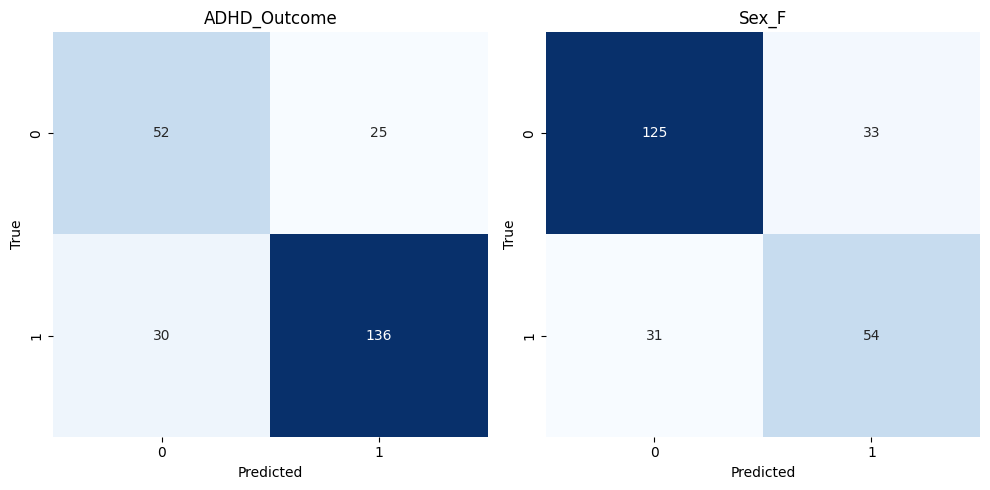

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrices for each label separately
cm = multilabel_confusion_matrix(y_test, y_pred)
num_labels = cm.shape[0]

# Plot confusion matrices
fig, axes = plt.subplots(1, num_labels, figsize=(5 * num_labels, 5))
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{y_test.columns[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

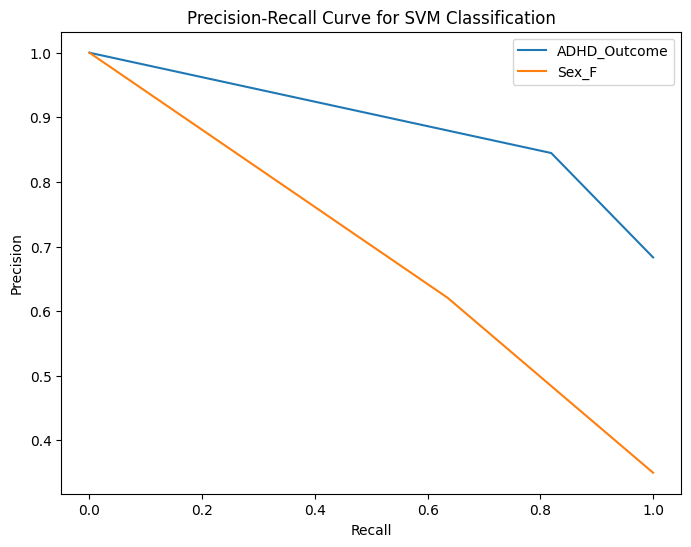

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate over columns with their names
    precision, recall, _ = precision_recall_curve(y_test[column_name], y_pred[:, i])
    plt.plot(recall, precision, label=f"{column_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM Classification")
plt.legend()
plt.show()


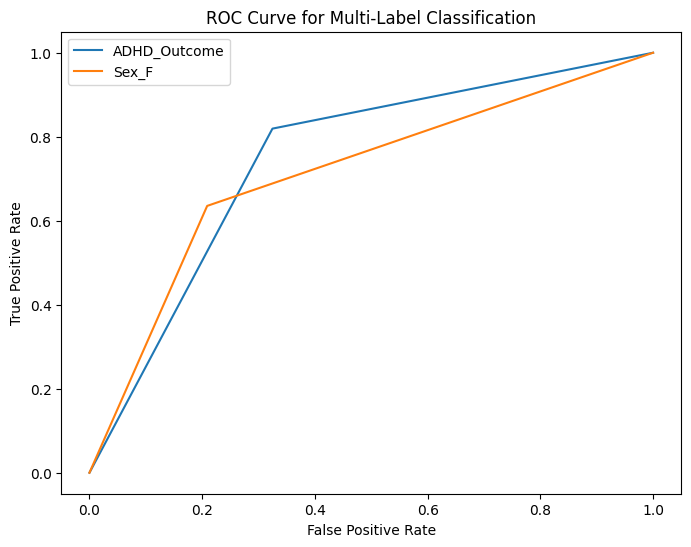

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve for each label
plt.figure(figsize=(8, 6))
for i, column_name in enumerate(y_test.columns):  # Iterate through columns with names
    fpr, tpr, _ = roc_curve(y_test[column_name], y_pred[:, i])  # Access column by name
    plt.plot(fpr, tpr, label=f"{column_name}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Label Classification")
plt.legend()
plt.show()

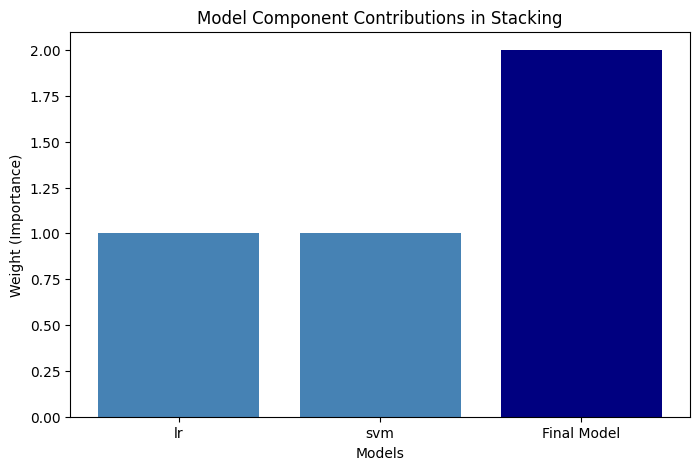

In [ ]:
# Assuming stacking_model is your trained StackingClassifier
base_models = [name for name, _ in stacking_model.estimators]
final_model = stacking_model.final_estimator

# Create a DataFrame showing model contributions
model_weights = pd.DataFrame({
    "Base Models": base_models + ["Final Model"],
    "Weight": [1] * len(base_models) + [2]  # Assume equal weights; adjust if needed
})

# Plot
plt.figure(figsize=(8, 5))
plt.bar(model_weights["Base Models"], model_weights["Weight"], color=["steelblue"]*len(base_models) + ["navy"])
plt.xlabel("Models")
plt.ylabel("Weight (Importance)")
plt.title("Model Component Contributions in Stacking")
plt.show()